In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Simple EncoderDecoder

Refer https://github.com/yogeshhk/MidcurveNN for more details, for now

## Installations

In [4]:
from __future__ import absolute_import, division, print_function, unicode_literals

# !pip install tensorflow-gpu==2.0.0-alpha0
import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.callbacks import EarlyStopping

import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output
from keras.preprocessing.image import img_to_array, load_img
from random import shuffle
import PIL
import json
import numpy as np
import sys
np.set_printoptions(threshold=sys.maxsize)
import matplotlib.pyplot as plt
import matplotlib
# matplotlib.use('TKAgg')
%matplotlib inline

In [5]:
input_data_folder = "../input/midcurvenn/images"

In [6]:
def read_input_image_pairs(datafolder=input_data_folder):
    profile_pngs = []
    midcurve_pngs = []
    for file in os.listdir(datafolder):
        fullpath = os.path.join(datafolder, file)
        if os.path.isdir(fullpath):
            continue
        if file.endswith(".png"):
            if file.find("Profile") != -1:
                profile_pngs.append(fullpath)
            if file.find("Midcurve") != -1:
                midcurve_pngs.append(fullpath)
    profile_pngs = sorted(profile_pngs)
    midcurve_pngs = sorted(midcurve_pngs)
    return profile_pngs,midcurve_pngs

In [7]:
def get_training_data(datafolder = input_data_folder):
    profile_pngs,midcurve_pngs = read_input_image_pairs(datafolder)
    
    profile_pngs_objs = [img_to_array(load_img(f, color_mode='rgba', target_size=(100, 100))) for f in profile_pngs ]
    midcurve_pngs_objs = [img_to_array(load_img(f, color_mode='rgba', target_size=(100, 100))) for f in midcurve_pngs]

    profile_pngs_gray_objs = [x[:,:,3] for x in profile_pngs_objs]
    midcurve_pngs_gray_objs =[x[:,:,3] for x in midcurve_pngs_objs]
    
        
    # shufle them
    zipped_profiles_midcurves = [(p,m) for p,m in zip(profile_pngs_gray_objs,midcurve_pngs_gray_objs)]
    shuffle(zipped_profiles_midcurves)
    profile_pngs_gray_objs, midcurve_pngs_gray_objs = zip(*zipped_profiles_midcurves)
    
    return profile_pngs_gray_objs, midcurve_pngs_gray_objs

In [8]:
profile_pngs_objs, midcurve_pngs_objs = get_training_data()

In [9]:
def plot_results(original_imgs,computed_imgs):
    n = 10  # how many digits we will display
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(original_imgs[i].reshape(100, 100),cmap='gray_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    
        # display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(computed_imgs[i].reshape(100, 100),cmap='gray_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

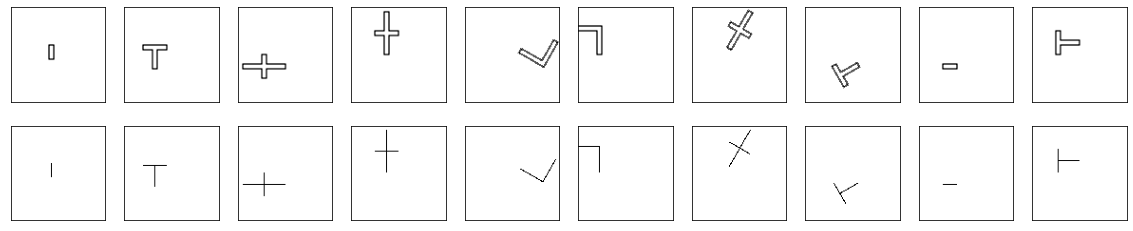

In [10]:
plot_results(profile_pngs_objs,midcurve_pngs_objs)

In [11]:
from keras import regularizers
from keras.layers import Input, Dense
from keras.models import Model, load_model
import os
import numpy as np
import sys
import random

np.set_printoptions(threshold=sys.maxsize)

class simple_encoderdecoder:
    def __init__(self):
        self.encoding_dim = 100
        self.input_dim = 10000
        self.epochs = 200
        self.batch_size = 5
        self.autoencoder_model_pkl = "models/autoencoder_model.pkl"
        self.encoder_model_pkl = "models/encoder_model.pkl"
        self.decoder_model_pkl = "models/decoder_model.pkl"
                
    def process_images(self,grayobjs):
        flat_objs = [x.reshape(self.input_dim) for x in grayobjs]
        pngs_objs = np.array(flat_objs)
        return pngs_objs

    def train(self,
            profile_pngs_gray_objs, 
            midcurve_pngs_gray_objs,
            retrain_model=False):
        
        if not os.path.exists(self.autoencoder_model_pkl) or retrain_model:
            # this is our input placeholder
            input_img = Input(shape=(self.input_dim,))
            
            # "encoded" is the encoded representation of the input
            encoded = Dense(self.encoding_dim, activation='relu',activity_regularizer=regularizers.l1(10e-5))(input_img)
            # "decoded" is the lossy reconstruction of the input
            decoded = Dense(self.input_dim, activation='sigmoid')(encoded) 
            
            # Model 1: Full AutoEncoder, includes both encoder single dense layer and decoder single dense layer. 
            # This model maps an input to its reconstruction
            self.autoencoder = Model(input_img, decoded)
                    
            # Model 2: a separate encoder model: -------------------
            # this model maps an input to its encoded representation
            self.encoder = Model(input_img, encoded)
            
            # Model 3: a separate encoder model: -------------------
            # create a placeholder for an encoded (32-dimensional) input
            encoded_input = Input(shape=(self.encoding_dim,))
            # retrieve the last layer of the autoencoder model
            decoder_layer = self.autoencoder.layers[-1]
            # create the decoder model
            self.decoder = Model(encoded_input, decoder_layer(encoded_input))
            
            # Compilation of Autoencoder (only)
            self.autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

            profile_pngs_objs = self.process_images(profile_pngs_gray_objs)
            midcurve_pngs_objs = self.process_images(midcurve_pngs_gray_objs)
            

            es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
            self.x = profile_pngs_objs
            self.y = midcurve_pngs_objs
            self.autoencoder.fit(self.x, self.y,
                        epochs=self.epochs,
                        batch_size=self.batch_size,
                        validation_split=0.3,
                        callbacks=[es],                                 
                        shuffle=True)                
            # Save models
            save_model(self.autoencoder,
                       self.autoencoder_model_pkl)  # self.autoencoder.save(self.autoencoder_model_pkl)
            save_model(self.encoder, self.encoder_model_pkl)  # self.encoder.save(self.encoder_model_pkl)
            save_model(self.decoder, self.decoder_model_pkl)  # self.decoder.save(self.decoder_model_pkl)
        else:
            # Save models
            self.autoencoder = load_model(self.autoencoder_model_pkl)
            self.encoder= load_model(self.encoder_model_pkl)
            self.decoder = load_model(self.decoder_model_pkl)
    
    def predict(self, test_profile_images):
        png_profile_images = self.process_images(test_profile_images)
        encoded_imgs = self.encoder.predict(png_profile_images)
        decoded_imgs = self.decoder.predict(encoded_imgs)    
        return test_profile_images,decoded_imgs  

In [12]:
profile_gray_objs, midcurve_gray_objs = get_training_data()
profile_gray_objs = np.asarray(profile_gray_objs) / 255.
midcurve_gray_objs = np.asarray(midcurve_gray_objs) / 255.

endec = simple_encoderdecoder()

endec.train(profile_gray_objs, midcurve_gray_objs)

Epoch 1/200
63/63 [==============================] - 2s 16ms/step - loss: 0.4960 - accuracy: 8.9233e-04 - val_loss: 0.0529 - val_accuracy: 0.0000e+00
Epoch 2/200
63/63 [==============================] - 0s 6ms/step - loss: 0.0504 - accuracy: 0.0000e+00 - val_loss: 0.0472 - val_accuracy: 0.0000e+00
Epoch 3/200
63/63 [==============================] - 0s 5ms/step - loss: 0.0442 - accuracy: 0.0000e+00 - val_loss: 0.0437 - val_accuracy: 0.0000e+00
Epoch 4/200
63/63 [==============================] - 0s 5ms/step - loss: 0.0395 - accuracy: 0.0041 - val_loss: 0.0409 - val_accuracy: 0.0000e+00
Epoch 5/200
63/63 [==============================] - 0s 5ms/step - loss: 0.0362 - accuracy: 0.0000e+00 - val_loss: 0.0381 - val_accuracy: 0.0000e+00
Epoch 6/200
63/63 [==============================] - 0s 5ms/step - loss: 0.0328 - accuracy: 0.0033 - val_loss: 0.0351 - val_accuracy: 0.0000e+00
Epoch 7/200
63/63 [==============================] - 0s 5ms/step - loss: 0.0290 - accuracy: 0.0101 - val_loss: 0.

In [15]:
test_gray_images = random.sample(list(profile_gray_objs),10)

In [16]:
original_profile_imgs,predicted_midcurve_imgs = endec.predict(test_gray_images)


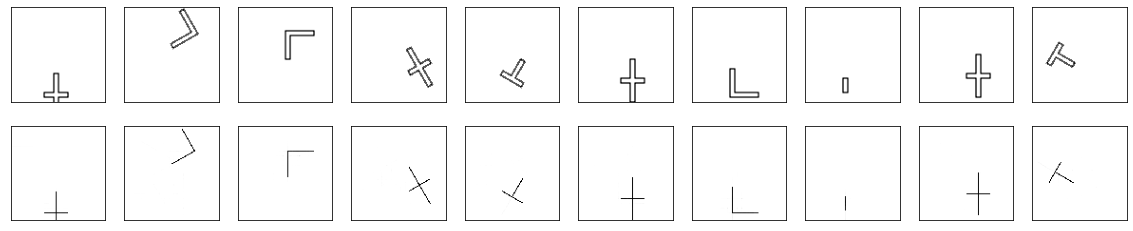

In [17]:
plot_results(original_profile_imgs,predicted_midcurve_imgs)